In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.utils import class_weight

#shuffle csv
from sklearn.utils import shuffle

#Multiprocessing
import multiprocessing
from tqdm import tqdm  # Barre de progression

#import feature
from src.phase_folding import create_folded_lightcurve

# TensorFlow
pr_auc = tf.keras.metrics.AUC(curve='PR', name='pr_auc')

print("Bibliothèques importées (avec multiprocessing et tqdm).")

Bibliothèques importées (avec multiprocessing et tqdm).


In [18]:
print("Chargement des données brutes...")
train_df = pd.read_csv('../data/raw/train.csv')

X_raw = train_df.drop('LABEL', axis=1).values
y = train_df['LABEL'].values - 1  # (0, 1)

print("Mélange des données...")
X_raw_shuffled, y_shuffled = shuffle(X_raw, y, random_state=42)

print(f"Forme de X_raw_shuffled : {X_raw_shuffled.shape}")
print(f"Forme de y_shuffled : {y_shuffled.shape}")

Chargement des données brutes...
Mélange des données...
Forme de X_raw_shuffled : (5087, 3197)
Forme de y_shuffled : (5087,)


In [3]:
N_BINS = 500

# On utilise les données complètes (mélangées) de la Cellule 2
X_data_to_process = X_raw_shuffled
y_data_to_process = y_shuffled

print(f"Démarrage du pré-traitement 'Phase Folding' PARALLÉLISÉ sur {len(X_data_to_process)} étoiles...")

# 1. Déterminer le nombre de cœurs
N_CORES = multiprocessing.cpu_count() - 1
if N_CORES < 1:
    N_CORES = 1
print(f"Utilisation de {N_CORES} cœurs CPU...")

# 2. Préparer les arguments pour la fonction
# (Notre fonction a besoin de 2 arguments : row et n_bins)
func_args = [(row, N_BINS) for row in X_data_to_process]

# 3. Créer un "pool" de workers et lancer le calcul
with multiprocessing.Pool(processes=N_CORES) as pool:
    # pool.starmap est fait pour les fonctions avec plusieurs arguments
    # tqdm ajoute la barre de progression
    X_folded = list(tqdm(pool.starmap(create_folded_lightcurve, func_args), total=len(X_data_to_process)))

# 4. Convertir la liste de résultats en array numpy
X_folded = np.array(X_folded)

# 5. y devient y_data_to_process pour la Cellule 4
y = y_data_to_process

print("Pré-traitement 'Phase Folding' terminé !")
print(f"Forme de X_folded (nos nouvelles features) : {X_folded.shape}")
print(f"Forme de y (cibles) : {y.shape}")

Démarrage du pré-traitement 'Phase Folding' PARALLÉLISÉ sur 5087 étoiles...
Utilisation de 7 cœurs CPU...


100%|██████████| 5087/5087 [00:00<00:00, 1655141.14it/s]

Pré-traitement 'Phase Folding' terminé !
Forme de X_folded (nos nouvelles features) : (5087, 500)
Forme de y (cibles) : (5087,)


In [20]:
print("Division des données complètes (Train/Test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_folded,  # <-- Données complètes
    y,         # <-- Données complètes
    test_size=0.2,
    random_state=42,
    stratify=y # Stratifier sur TOUTES les données
)

# Redimensionner pour le CNN
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

INPUT_SHAPE = (N_BINS, 1)

print(f"Forme X_train_cnn : {X_train_cnn.shape}")
print(f"Forme X_test_cnn : {X_test_cnn.shape}")
print(f"Classes dans y_train : {np.unique(y_train, return_counts=True)}")
print(f"Classes dans y_test : {np.unique(y_test, return_counts=True)}")

Division des données complètes (Train/Test)...
Forme X_train_cnn : (4069, 500, 1)
Forme X_test_cnn : (1018, 500, 1)
Classes dans y_train : (array([0, 1]), array([4039,   30]))
Classes dans y_test : (array([0, 1]), array([1011,    7]))


In [21]:
# Le v10 était en underfitting adding more capacity .

def build_phase_model_v13(input_shape):
    model = tf.keras.models.Sequential(name="CNN_v13_Deeper")

    model.add(tf.keras.layers.Input(shape=input_shape))

    # 1er Bloc (plus de filtres)
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    # 2ème Bloc
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    # 3ème Bloc (encore plus profond)
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    # Tête de classification (plus de neurones)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

model = build_phase_model_v13(INPUT_SHAPE)

# Compiler avec le même optimisateur
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc] # On suit toujours le PR-AUC
)

model.summary()

Model: "CNN_v13_Deeper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 500, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 166, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 166, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 166, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 55, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 55, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,849 (714.25 KB)

 Trainable params: 182,849 (714.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Calculer les poids basés sur le SET D'ENTRAÎNEMENT (y_train)
# C'est la seule chose que le modèle doit voir
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Keras attend un dictionnaire
class_weights_dict = {0: weights[0], 1: weights[1]}

print(f"Poids de classe (Classe 0 'Pas Planète'): {weights[0]:.2f}")
print(f"Poids de classe (Classe 1 'Planète'):   {weights[1]:.2f}")

Poids de classe (Classe 0 'Pas Planète'): 0.50
Poids de classe (Classe 1 'Planète'):   67.82


In [24]:
# Noms de fichiers pour la v12
LOG_DIR = './logs/v13_phase_folding_fastLR'
MODEL_PATH = '../models/cnn_v13_phase_folding_best.h5'

# 1. Nettoyer les anciens logs (version Windows)
!rmdir /S /Q .\\logs\\v13_phase_folding_fastLR

# 2. Définir les Callbacks (LE CODE QUI MANQUAIT)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    save_best_only=True,
    monitor='val_pr_auc', # Toujours notre métrique clé
    mode='max',
    verbose=1
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 3. Entraînement
print(f"Début de l'entraînement (v13 - LR augmented)...")
history = model.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),

    # On passe les callbacks qui sont maintenant définis
    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb],

    # Et on ajoute la nouvelle ligne magique
    class_weight=class_weights_dict
)

Début de l'entraînement (v13 - LR augmented)...
Epoch 1/100


.\\logs\\v13_phase_folding_fastLR\train\events.out.tfevents.1761992595.LAPTOP-4FMB7BF0.16308.2.v2 - AccŠs refus‚.


127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9667 - loss: 1.2197 - pr_auc: 0.0063
Epoch 1: val_pr_auc improved from None to 0.01190, saving model to ../models/cnn_v13_phase_folding_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9843 - loss: 0.9498 - pr_auc: 0.0064 - val_accuracy: 0.7603 - val_loss: 0.6791 - val_pr_auc: 0.0119
Epoch 2/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9619 - loss: 0.6508 - pr_auc: 0.0056
Epoch 2: val_pr_auc did not improve from 0.01190
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9545 - loss: 0.7172 - pr_auc: 0.0074 - val_accuracy: 0.9538 - val_loss: 0.6263 - val_pr_auc: 0.0067
Epoch 3/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8612 - loss: 0.7015 - pr_auc: 0.0131
Epoch 3: val_pr_auc did not improve from 0.01190
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7786 - loss: 0.7445 - pr_auc: 0.0072 - val_accuracy: 0.1130 - val_loss: 0.6938 - val_pr_auc: 0.0070
Epoch 4/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5058 - loss: 0.6538 - pr_auc: 0.0056
Epoch 4: val_pr_auc did not improve from 0.01190
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5281 - loss: 0

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5739 - loss: 0.6514 - pr_auc: 0.0091 - val_accuracy: 0.5766 - val_loss: 0.6163 - val_pr_auc: 0.0120
Epoch 7/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5953 - loss: 0.6567 - pr_auc: 0.0078
Epoch 7: val_pr_auc did not improve from 0.01199
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5849 - loss: 0.6549 - pr_auc: 0.0091 - val_accuracy: 0.7122 - val_loss: 0.4820 - val_pr_auc: 0.0078
Epoch 8/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6198 - loss: 0.8374 - pr_auc: 0.0416
Epoch 8: val_pr_auc improved from 0.01199 to 0.03385, saving model to ../models/cnn_v13_phase_folding_best.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6505 - loss: 0.6978 - pr_auc: 0.0163 - val_accuracy: 0.6198 - val_loss: 0.6056 - val_pr_auc: 0.0338
Epoch 9/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7137 - loss: 0.6650 - pr_auc: 0.0402
Epoch 9: val_pr_auc did not improve from 0.03385
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7056 - loss: 0.6634 - pr_auc: 0.0129 - val_accuracy: 0.5049 - val_loss: 0.6250 - val_pr_auc: 0.0070
Epoch 10/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6238 - loss: 0.6283 - pr_auc: 0.0541
Epoch 10: val_pr_auc did not improve from 0.03385
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5820 - loss: 0.6442 - pr_auc: 0.0152 - val_accuracy: 0.3399 - val_loss: 0.6487 - val_pr_auc: 0.0069
Epoch 11/100
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5387 - loss: 0.7467 - pr_auc: 0.0164
Epoch 11: val_pr_auc did not improve from 0.03385
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6090 - los

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5023 - loss: 0.6934 - pr_auc: 0.0186 - val_accuracy: 0.2583 - val_loss: 0.6956 - val_pr_auc: 0.0342
Epoch 18/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4782 - loss: 0.6074 - pr_auc: 0.0189
Epoch 18: val_pr_auc did not improve from 0.03418
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4896 - loss: 0.6239 - pr_auc: 0.0301 - val_accuracy: 0.3389 - val_loss: 0.6989 - val_pr_auc: 0.0163
Epoch 19/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4348 - loss: 0.6460 - pr_auc: 0.0855
Epoch 19: val_pr_auc did not improve from 0.03418
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5075 - loss: 0.6088 - pr_auc: 0.0264 - val_accuracy: 0.6847 - val_loss: 0.5373 - val_pr_auc: 0.0071
Epoch 20/100
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4870 - loss: 0.7099 - pr_auc: 0.1135
Epoch 20: val_pr_auc did not improve from 0.03418
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5127 - l

In [25]:
print("Évaluation du meilleur modèle v13 (restauré)...")

# Prédictions
y_pred_proba = model.predict(X_test_cnn).ravel()
y_pred_class = (y_pred_proba > 0.5).astype(int)

# Rapports
print("\n--- Rapport de Classification (v13) ---")
print(classification_report(y_test, y_pred_class, target_names=['Pas de Planète', 'Planète']))

print("\n--- Matrice de Confusion (v13) ---")
print(confusion_matrix(y_test, y_pred_class))

# LE VRAI SCORE PR-AUC (Average Precision)
# (Assurez-vous d'importer average_precision_score depuis sklearn.metrics)
try:
    pr_auc_score = average_precision_score(y_test, y_pred_proba)
    print(f"\nScore PR-AUC (Average Precision) : {pr_auc_score:.4f}")
except NameError:
    print("\nN'oubliez pas d'importer 'average_precision_score' pour voir le score PR-AUC.")

Évaluation du meilleur modèle v13 (restauré)...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

--- Rapport de Classification (v13) ---
                precision    recall  f1-score   support

Pas de Planète       1.00      0.25      0.41      1011
       Planète       0.01      0.86      0.02         7

      accuracy                           0.26      1018
     macro avg       0.50      0.56      0.21      1018
  weighted avg       0.99      0.26      0.40      1018


--- Matrice de Confusion (v13) ---
[[257 754]
 [  1   6]]

Score PR-AUC (Average Precision) : 0.0576


Affichage des graphiques d'entraînement (v13)...


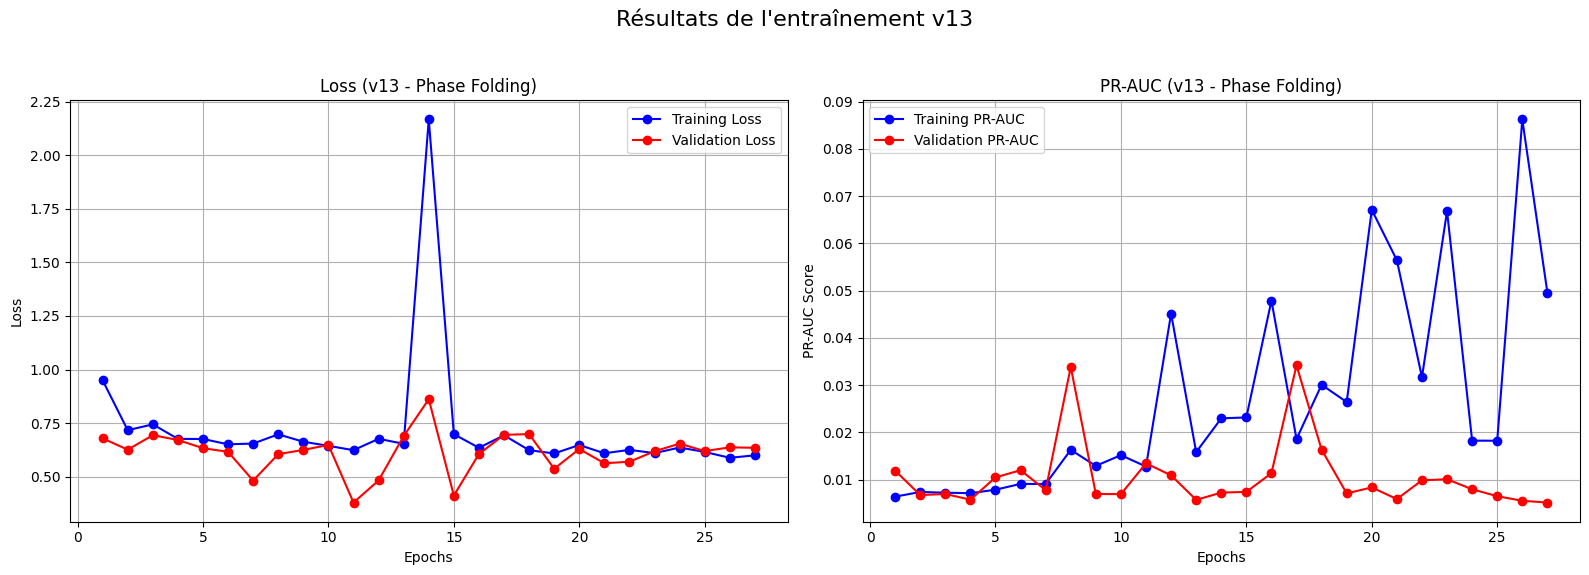

In [26]:
print("Affichage des graphiques d'entraînement (v13)...")
history_dict = history.history

# Récupérer les métriques
loss = history_dict['loss']
val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']
val_pr_auc = history_dict['val_pr_auc']

# Créer la plage d'époques (nombre d'époques réellement exécutées)
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)

# Créer la figure
plt.figure(figsize=(16, 6))

# Graphique 1 : Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss (v13 - Phase Folding)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Graphique 2 : PR-AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('PR-AUC (v13 - Phase Folding)')
plt.xlabel('Epochs')
plt.ylabel('PR-AUC Score')
plt.legend()
plt.grid(True)

plt.suptitle("Résultats de l'entraînement v13", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()